## Lib import

In [22]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

from tqdm.notebook import tqdm_notebook

## Declare functions

In [23]:
def data_to_xy(df, window_size):
    close = df['close'].values
    X = []
    y = []
    for i in range(len(df)-window_size):
        pattern = [[a] for a in close[i:i+window_size]]
        X.append(pattern)
        label = close[i+window_size]
        y.append(label)
        
    return np.array(X), np.array(y)

def xy_to_train(X, y, train_percentage=0.75, val_percentage=0.1):
    train_size = int(len(X) * train_percentage)
    val_size = int(len(X) * val_percentage) + train_size

    X_train, y_train = X[0:train_size], y[0:train_size]
    X_val, y_val = X[train_size:val_size], y[train_size:val_size]
    X_test, y_test = X[val_size:len(X)], y[val_size:len(X)]

    return X_train, X_val, X_test, y_train, y_val, y_test


def build_model():
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1],1)),
        Dense(8, activation='relu'),
        Dense(1)
    ])
    
    optimizer = Adam(0.01)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', RootMeanSquaredError()])
    return model

## Load data

In [24]:
# Choose ticker (in case of crypto: ticker+stable)
ticker = 'ETH-USD'

# Choose start date
start_date = '2019-06-01'

# Choose end date
end_date = '2022-12-20'

In [35]:
#data = pdr.data.DataReader(ticker, 'yahoo', start=start_date, end=end_date)
data = pd.read_csv('MSFT.csv')
data['date'] = pd.to_datetime(data['date'])

In [36]:
data.head()

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2017-12-07 00:00:00+00:00,82.49,82.80,82.00,82.54,20378114,77.664717,77.956583,77.203379,77.711792,20378114,0.0,1.0
1,2017-12-08 00:00:00+00:00,84.16,84.58,83.33,83.63,23825056,79.237029,79.632461,78.455581,78.738032,23825056,0.0,1.0
2,2017-12-11 00:00:00+00:00,85.23,85.37,84.12,84.29,19909119,80.244439,80.376250,79.199369,79.359425,19909119,0.0,1.0
3,2017-12-12 00:00:00+00:00,85.58,86.05,85.08,85.31,23534946,80.573966,81.016473,80.103214,80.319760,23534946,0.0,1.0
4,2017-12-13 00:00:00+00:00,85.35,86.00,85.17,85.74,21307911,80.357420,80.969398,80.187949,80.724607,21307911,0.0,1.0


## Data transformation

In [37]:
X, y = data_to_xy(data, window_size=30)
X.shape, y.shape

((1227, 30, 1), (1227,))

In [38]:
X_train, X_val, X_test, y_train, y_val, y_test = xy_to_train(X, y)
X_train.shape, X_val.shape, X_test.shape

((920, 30, 1), (122, 30, 1), (185, 30, 1))

## Model training

In [39]:
keras.backend.clear_session()
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [40]:
epochs = 100
batch_size = 50
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                   validation_data=(X_val, y_val)).history

Epoch 1/100
19/19 [==============================] - 2s 28ms/step - loss: 29902.6973 - mae: 162.2342 - mse: 29902.6973 - root_mean_squared_error: 172.9240 - val_loss: 93140.2969 - val_mae: 304.5892 - val_mse: 93140.2969 - val_root_mean_squared_error: 305.1890
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 25084.8906 - mae: 146.4787 - mse: 25084.8906 - root_mean_squared_error: 158.3821 - val_loss: 77713.2266 - val_mae: 278.1145 - val_mse: 77713.2266 - val_root_mean_squared_error: 278.7709
Epoch 3/100
19/19 [==============================] - 0s 11ms/step - loss: 16022.6416 - mae: 110.4423 - mse: 16022.6416 - root_mean_squared_error: 126.5806 - val_loss: 53758.5039 - val_mae: 231.0691 - val_mse: 53758.5039 - val_root_mean_squared_error: 231.8588
Epoch 4/100
19/19 [==============================] - 0s 11ms/step - loss: 7116.3354 - mae: 64.1288 - mse: 7116.3354 - root_mean_squared_error: 84.3584 - val_loss: 31309.0820 - val_mae: 175.9077 - val_mse: 31309.0820 - va

Epoch 34/100
19/19 [==============================] - 0s 12ms/step - loss: 13.3555 - mae: 2.6656 - mse: 13.3555 - root_mean_squared_error: 3.6545 - val_loss: 518.2466 - val_mae: 17.9931 - val_mse: 518.2466 - val_root_mean_squared_error: 22.7650
Epoch 35/100
19/19 [==============================] - 0s 11ms/step - loss: 17.0365 - mae: 3.0618 - mse: 17.0365 - root_mean_squared_error: 4.1275 - val_loss: 492.2033 - val_mae: 17.2169 - val_mse: 492.2033 - val_root_mean_squared_error: 22.1857
Epoch 36/100
19/19 [==============================] - 0s 11ms/step - loss: 13.4833 - mae: 2.6303 - mse: 13.4833 - root_mean_squared_error: 3.6720 - val_loss: 500.4200 - val_mae: 17.7283 - val_mse: 500.4200 - val_root_mean_squared_error: 22.3701
Epoch 37/100
19/19 [==============================] - 0s 11ms/step - loss: 17.3703 - mae: 3.0537 - mse: 17.3703 - root_mean_squared_error: 4.1678 - val_loss: 525.2460 - val_mae: 18.7544 - val_mse: 525.2460 - val_root_mean_squared_error: 22.9182
Epoch 38/100
19/19 [

19/19 [==============================] - 0s 11ms/step - loss: 13.2706 - mae: 2.6241 - mse: 13.2706 - root_mean_squared_error: 3.6429 - val_loss: 359.3704 - val_mae: 14.7091 - val_mse: 359.3704 - val_root_mean_squared_error: 18.9571
Epoch 68/100
19/19 [==============================] - 0s 11ms/step - loss: 13.0110 - mae: 2.5769 - mse: 13.0110 - root_mean_squared_error: 3.6071 - val_loss: 340.9258 - val_mae: 14.1898 - val_mse: 340.9258 - val_root_mean_squared_error: 18.4642
Epoch 69/100
19/19 [==============================] - 0s 11ms/step - loss: 15.1414 - mae: 2.8210 - mse: 15.1414 - root_mean_squared_error: 3.8912 - val_loss: 346.1260 - val_mae: 14.3094 - val_mse: 346.1260 - val_root_mean_squared_error: 18.6045
Epoch 70/100
19/19 [==============================] - 0s 11ms/step - loss: 17.7261 - mae: 3.1424 - mse: 17.7261 - root_mean_squared_error: 4.2102 - val_loss: 332.0722 - val_mae: 14.1877 - val_mse: 332.0722 - val_root_mean_squared_error: 18.2228
Epoch 71/100
19/19 [=============

19/19 [==============================] - 0s 11ms/step - loss: 16.2828 - mae: 2.9275 - mse: 16.2828 - root_mean_squared_error: 4.0352 - val_loss: 346.8040 - val_mae: 14.6277 - val_mse: 346.8040 - val_root_mean_squared_error: 18.6227


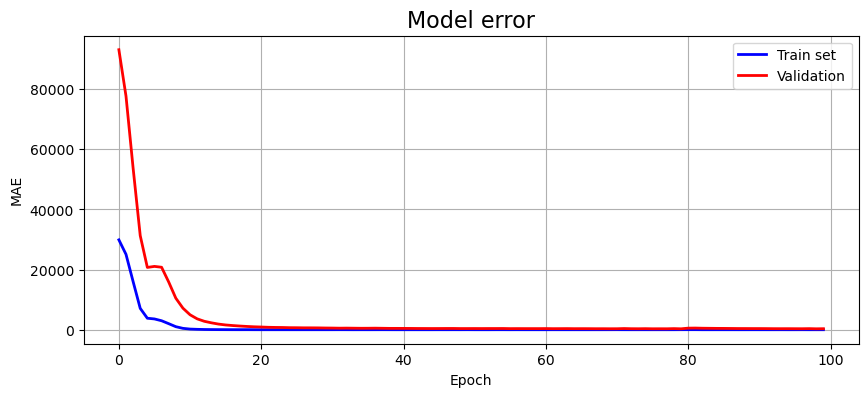

In [41]:
#plot the training losses
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(history['loss'], 'b', label='Train set', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model error', fontsize=16)
ax.set_ylabel('MAE')
ax.set_xlabel('Epoch')
ax.legend(loc='best')
ax.grid()
plt.show()

## Prediction

In [42]:
prediction = model.predict(X_test).flatten()
Y = y_test

MSE = mean_squared_error(Y, prediction)
Var_Exp = explained_variance_score(Y, prediction)
R2 = r2_score(Y, prediction)
corr = math.sqrt(abs(R2))
error = prediction-Y
mean = np.mean(error)
std = np.std(error)

6/6 [==============================] - 0s 3ms/step


Error standard deviation is 6.45 USD
Mean squared error is 44.05
Coefficiant of determination is 0.911
Correlation coefficient is 0.955
Variance explained score is 0.916


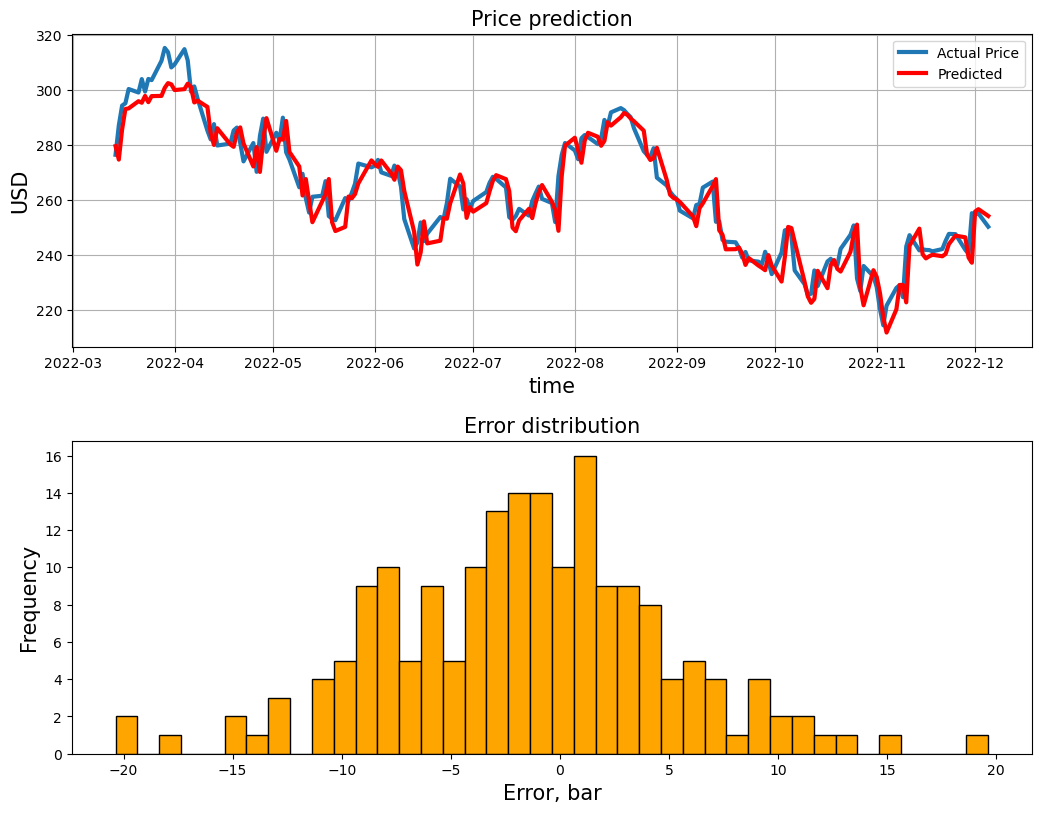

In [43]:
print('Error standard deviation is ' + str("{:.2f}".format(std)) + ' USD')
print('Mean squared error is ' + str("{:.2f}".format(MSE)))
print('Coefficiant of determination is ' + str("{:.3f}".format(R2)))
print('Correlation coefficient is ' + str("{:.3f}".format(corr)))
print('Variance explained score is ' + str("{:.3f}".format(Var_Exp)))

plt.subplot(2,1,1)
plt.plot(data.date[X_train.shape[0]+X_val.shape[0]+30:], y_test, linewidth=3, label='Actual Price')
plt.plot(data.date[X_train.shape[0]+X_val.shape[0]+30:], prediction, linewidth=3, c='r', label='Predicted')
plt.title('Price prediction', fontsize=15); 
plt.ylabel('USD', fontsize=15); plt.xlabel('time', fontsize=15)
#plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.legend(); plt.grid()

plt.subplot(2,1,2)
plt.hist(error, color = 'orange',edgecolor='black', bins=40)
plt.ylabel('Frequency', fontsize=15); plt.xlabel('Error, bar', fontsize=15)
#plt.xticks(fontsize=15); plt.yticks(fontsize=15);
plt.title('Error distribution', fontsize=15)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.15, hspace=0.3)
plt.show()